# Datathon

## 분석 목표
묶음 판매 행사를 열기 위해 어떤 품목을 많이 구매를 하였는지 파악하고, 구매한 품목 별 관계를 통해 세트로 판매할 품목을 정하고자 한다.

In [40]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# 데이터 불러오기
dirpath = "./dataset/"
datasets = os.listdir(dirpath)
aisles = pd.read_csv(dirpath+datasets[0])
departments = pd.read_csv(dirpath+datasets[1])
orders = pd.read_csv(dirpath+datasets[2])
order_products_prior = pd.read_csv(dirpath+datasets[3])
# order_products_train = pd.read_csv(dirpath+datasets[4]) # 일단 prior만 사용
products = pd.read_csv(dirpath+datasets[5])

In [3]:
print(aisles.shape)
aisles.head()

(134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
print(departments.shape)
departments.head()

(21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [5]:
print(orders.shape)
orders.head()

(3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:
print(order_products_prior.shape)
order_products_prior.head()

(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
print(products.shape)
products.head()

(49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


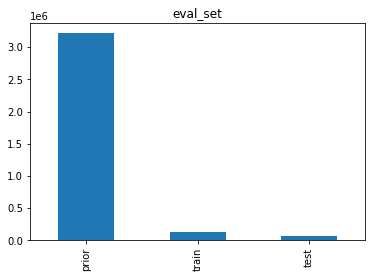

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64


In [8]:
orders_eval = orders['eval_set'].value_counts()
orders_eval.plot(kind='bar', title='eval_set')
plt.show()
print(orders_eval)

In [9]:
orders = orders.loc[orders.eval_set=="prior"] # prior data만 사용
print(orders.shape)

(3214874, 7)


In [10]:
tmp_df = pd.merge(order_products_prior, products, on="product_id", how="left")
print(tmp_df.shape)
tmp_df.head()

(32434489, 7)


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,2,28985,2,1,Michigan Organic Kale,83,4
2,2,9327,3,0,Garlic Powder,104,13
3,2,45918,4,1,Coconut Butter,19,13
4,2,30035,5,0,Natural Sweetener,17,13


In [11]:
tmp_df = pd.merge(tmp_df, aisles, on="aisle_id", how="left")
print(tmp_df.shape)
tmp_df.head()

(32434489, 8)


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients


In [12]:
tmp_df = pd.merge(tmp_df, departments, on="department_id", how="left")
print(tmp_df.shape)
tmp_df.head()

(32434489, 9)


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


<AxesSubplot:xlabel='count', ylabel='aisle'>

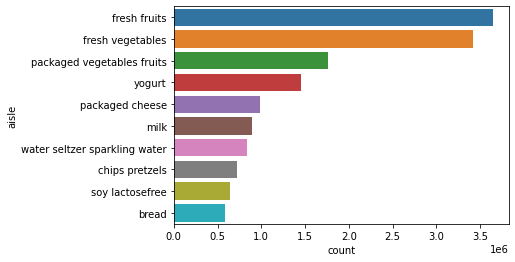

In [13]:
# 어느 진열대에서 많이 팔렸는가?
sns.countplot(y="aisle", data=tmp_df, order = tmp_df.aisle.value_counts().iloc[:10].index) # 상위 10개

<AxesSubplot:xlabel='count', ylabel='product_name'>

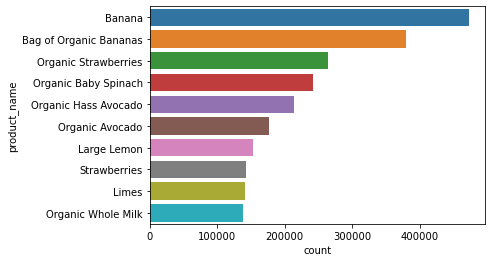

In [14]:
# 주문 품목 순위
sns.countplot(y="product_name", data=tmp_df, order = tmp_df.product_name.value_counts().iloc[:10].index) # 상위 10개

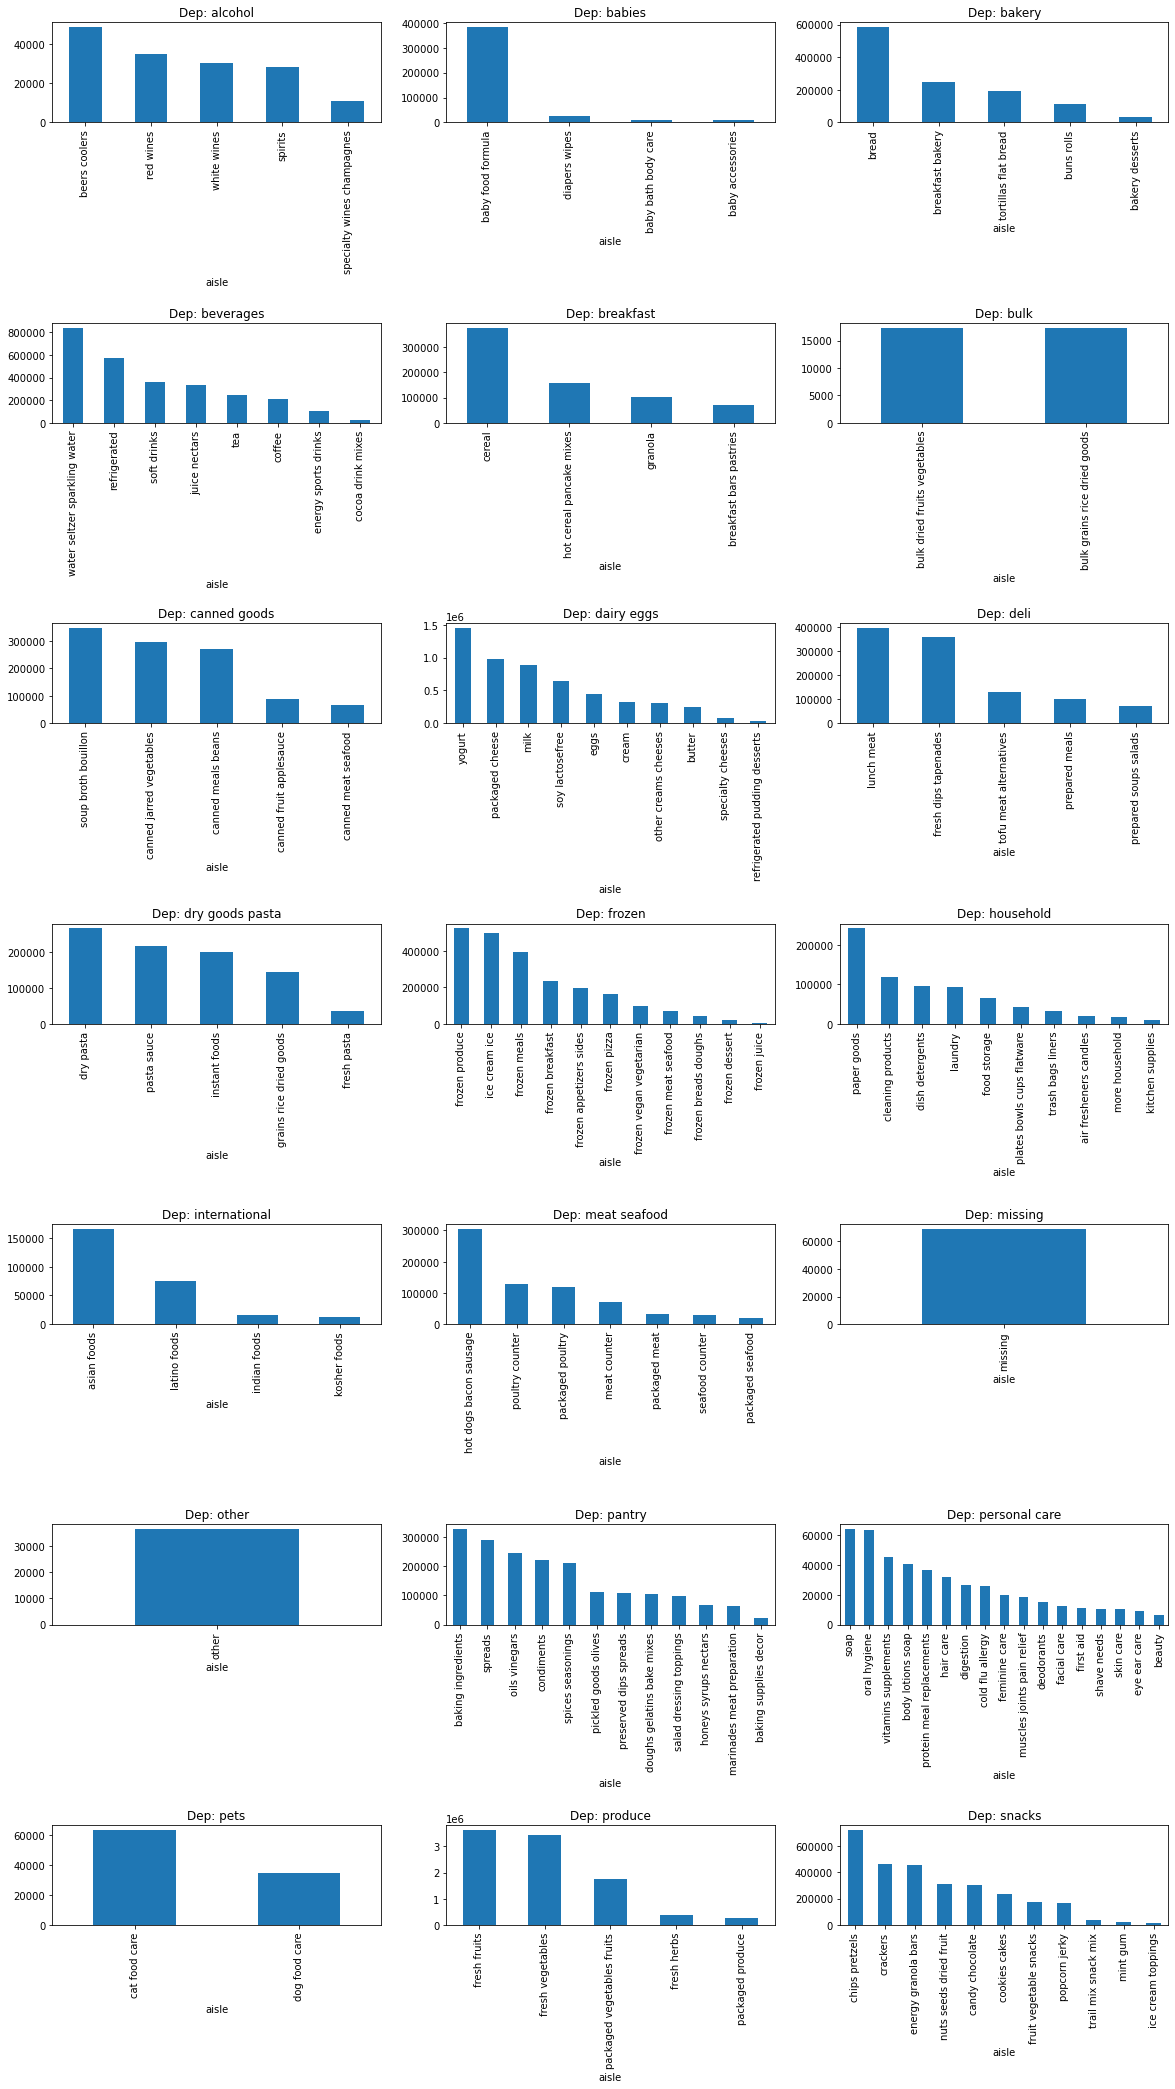

In [15]:
# 품목별 판매량 bar plot
f, axarr = plt.subplots(7, 3, figsize=(20, 35))
for i,e in enumerate(departments.department.sort_values(ascending=True)):
    axarr[i//3, i%3].set_title('Dep: {}'.format(e))
    tmp_df[tmp_df.department==e].groupby(['aisle']).count()['product_id']\
    .sort_values(ascending=False).plot(kind='bar', ax=axarr[i//3, i%3])
f.subplots_adjust(hspace=2)

위 표 노트북에서처럼 트리맵으로 그리면 더 가독성이 좋을 것 같은데 그렇게 해볼지 고민입니다

<AxesSubplot:xlabel='count', ylabel='department'>

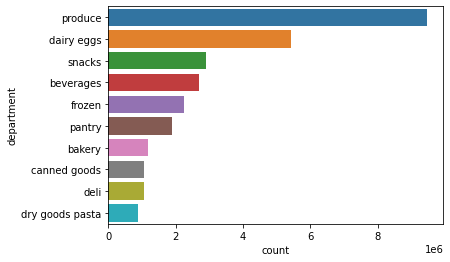

In [16]:
# 많이 팔린 department
sns.countplot(y="department", data=tmp_df, order = tmp_df.department.value_counts().iloc[:10].index) # 상위 10개

<AxesSubplot:xlabel='order_dow', ylabel='count'>

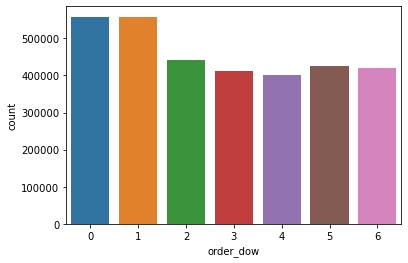

In [17]:
# 주문 요일
sns.countplot(x="order_dow", data=orders)

<AxesSubplot:xlabel='order_hour_of_day', ylabel='count'>

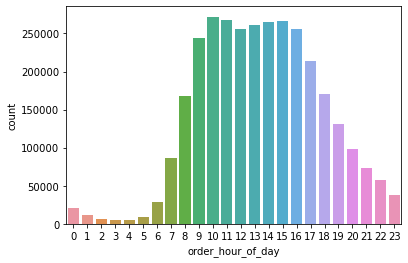

In [18]:
# 주문 시간
sns.countplot(x="order_hour_of_day", data=orders)

<AxesSubplot:xlabel='order_dow', ylabel='order_hour_of_day'>

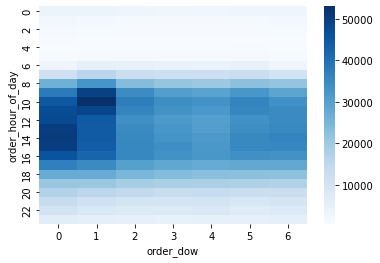

In [19]:
tmp = pd.crosstab(orders["order_hour_of_day"], orders["order_dow"])
sns.heatmap(tmp, cmap="Blues")

아침~오후에 주문이 주로 많고, 일요일, 월요일에 주문량이 더 많다. <br>
특히 월요일 오전, 일요일 오후에 주문이 많다.

<AxesSubplot:xlabel='days_since_prior_order', ylabel='count'>

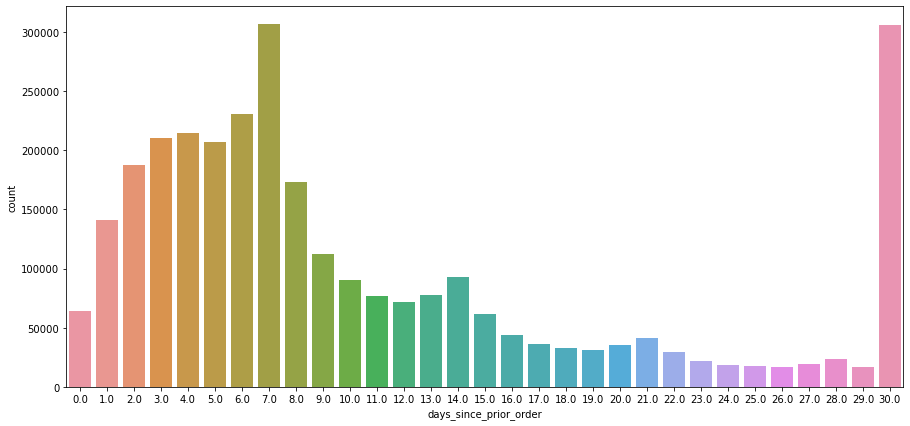

In [20]:
# 재구매 빈도
plt.figure(figsize=(15, 7))
sns.countplot(x="days_since_prior_order", data=orders)

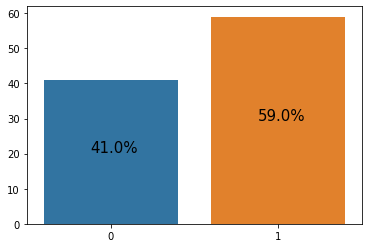

In [21]:
# 재구매율
tmp = tmp_df.reordered.value_counts(normalize=True)
tmp = tmp.mul(100).round(decimals=1)

ax = sns.barplot(x=tmp.index, y=tmp.values)
for p in ax.patches:
    percentage = f'{p.get_height()}%'
    x = p.get_x() + p.get_width() / 2 - 0.12
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), size = 15)

plt.show()

In [22]:
tmp_df = pd.merge(tmp_df, orders, on="order_id", how="left")

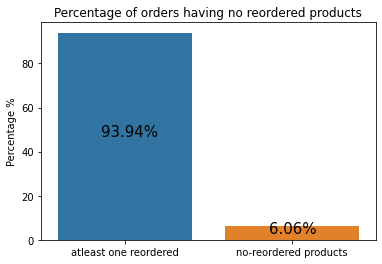

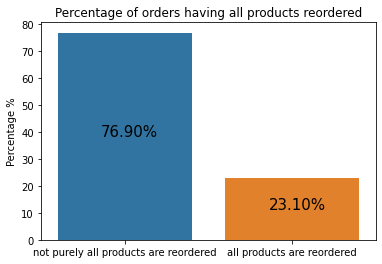

In [23]:
grouped_df = tmp_df.groupby(['order_id']).agg({'reordered':'mean', 'order_number':'first'}).reset_index().rename(columns={'reordered':'reordered_ratio'})
grouped_df['no_reordered'] = grouped_df['reordered_ratio'] == 0
grouped_df['all_reordered'] = grouped_df['reordered_ratio'] == 1.0

# 재주문인 것 찾아서 더하기
non_first_orders_Mask = orders.order_number != 1
non_first_orders_count = np.sum(non_first_orders_Mask)

# 재주문 품목이 있는 주문 vs 없는 주문
grouped_df = grouped_df[grouped_df.order_number != 1]
grouped_df['no_reordered'] = grouped_df['reordered_ratio'] == 0
no_reordered_count = grouped_df['no_reordered'].value_counts()/non_first_orders_count * 100
ax = sns.barplot(x=no_reordered_count.index, y=no_reordered_count.values)
ax.set_xticklabels(['atleast one reordered', 'no-reordered products'])
for p in ax.patches:
    percentage = f'{p.get_height():.2f}%'
    x = p.get_x() + p.get_width() / 2 - 0.14
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), size = 15)
plt.title('Percentage of orders having no reordered products')
plt.ylabel('Percentage %')
plt.show()

# 모든 품목이 재주문인 주문의 비율
grouped_df['all_reordered'] = grouped_df['reordered_ratio'] == 1.0
all_reordered_count = grouped_df['all_reordered'].value_counts()/non_first_orders_count * 100
ax = sns.barplot(x=all_reordered_count.index, y=all_reordered_count.values)
ax.set_xticklabels(['not purely all products are reordered', 'all products are reordered'])
for p in ax.patches:
    percentage = f'{p.get_height():.2f}%'
    x = p.get_x() + p.get_width() / 2 - 0.14
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), size = 15)
plt.title('Percentage of orders having all products reordered')
plt.ylabel('Percentage %')
plt.show()

grouped_df.head()
del grouped_df

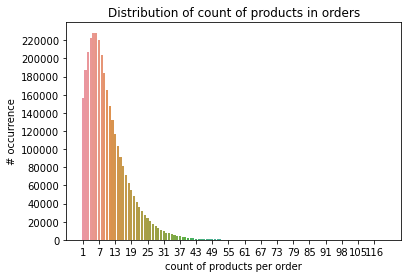

In [24]:
count_of_products = tmp_df.groupby(['order_id'], as_index=False)['product_id'].count()
sns.countplot(x='product_id', data=count_of_products)
plt.xlabel('count of products per order')
plt.ylabel('# occurrence')
plt.title('Distribution of count of products in orders')
plt.locator_params(nbins=20)
plt.show()

del count_of_products

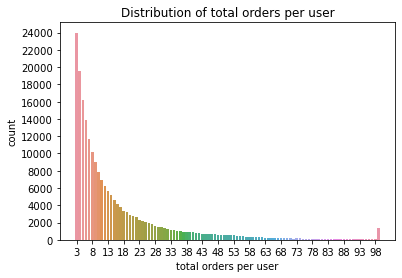

In [25]:
# 고객별 총 주문 수
total_orders = orders.groupby(['user_id'], as_index=False)['order_id'].count()
sns.countplot(x='order_id', data=total_orders)
plt.xlabel('total orders per user')
plt.ylabel('count')
plt.title('Distribution of total orders per user')
plt.locator_params(nbins=20)
plt.show()

del total_orders

In [26]:
# 시간대 별 인기 품목


In [27]:
# 재구매율이 높은 상품


# 고객 클러스터링
- 고객이 구매한 상품의 진열대를 기준으로 클러스터링을 진행한다.


In [33]:
cluster_df = tmp_df.drop('department', axis=1)

del tmp_df

In [77]:
# 어떤 진열대의 상품을 구매했는지
user_aisle = pd.crosstab(cluster_df.user_id, cluster_df.aisle)
print(user_aisle.shape)
user_aisle.head()

(206209, 134)


aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [147]:
pca = PCA(n_components=6) # 진열대들을 6개의 feature로 축소
pca.fit(user_aisle)
pca_samples = pca.transform(user_aisle)

In [148]:
ps_df = pd.DataFrame(pca_samples)
ps_df.head()

,0,1,2,3,4,5
0,-24.215659,2.429427,-2.466368,-0.145693,0.268933,-1.432577
1,6.463208,36.751116,8.382551,15.097534,-6.920797,-0.978906
2,-7.990302,2.404383,-11.030063,0.672234,-0.442415,-2.823192
3,-27.991129,-0.755823,-1.921732,2.091889,-0.288201,0.926065
4,-19.896394,-2.637225,0.533229,3.679230,0.612814,-1.623979


(PC4,PC1) 쌍이 각 구성 요소가 원본 데이터 집합의 모든 점을 projection한 것이므로 각 구성 요소가 데이터 집합을 대표한다고 생각한다

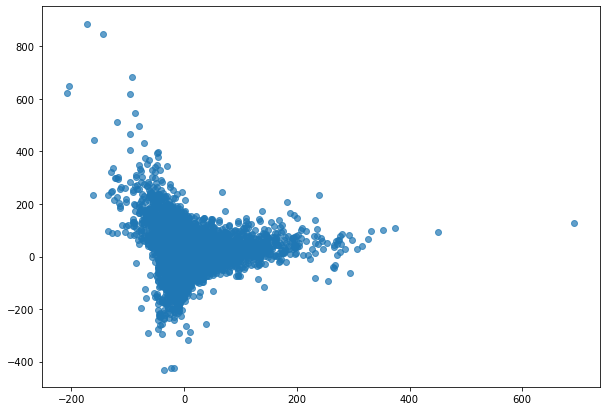

In [149]:
to_cluster = pd.DataFrame(ps_df[[4,1]])

plt.figure(figsize=(10, 7))
plt.scatter(to_cluster[4], to_cluster[1], alpha=0.7)
plt.show()

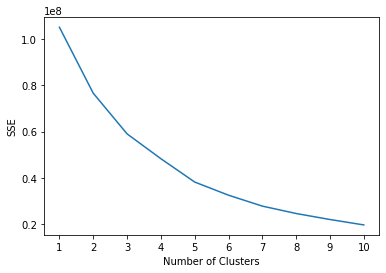

In [150]:
sse = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(to_cluster)
    sse.append(kmeans.inertia_)
    
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

elbow method를 사용했을 때 `k=5`가 최적의 k라고 하지만, `k=5`일 때 두 클러스터의 중심점이 거의 붙어있고, 두 클러스터 내 고객의 구매 상품군도 비슷하기 때문에 `k=4`로 지정하였다.

In [209]:
kmeans = KMeans(n_clusters=4, random_state=42).fit(to_cluster)
centers = kmeans.cluster_centers_
y_clusters = kmeans.predict(to_cluster)

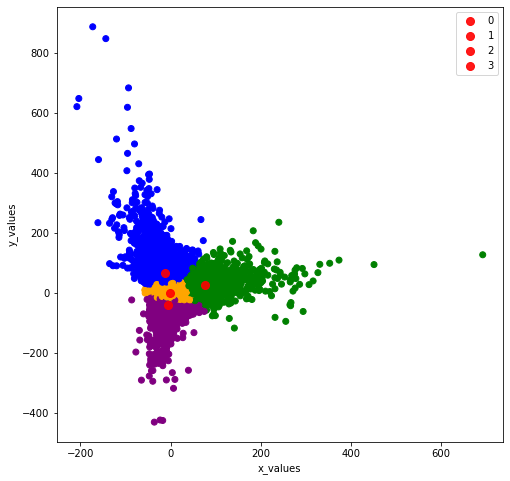

In [210]:
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple','green','yellow']
colored = [colors[k] for k in y_clusters]
plt.scatter(to_cluster[4], to_cluster[1], color = colored)
# plt.scatter(ps_df[0], ps_df[1], color=colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [223]:
cluster_product = user_aisle.copy()
cluster_product["cluster"] = y_clusters

cluster_product.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,3,0,0,0,0,2,0,0,0,...,1,1,0,0,0,0,2,0,42,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0


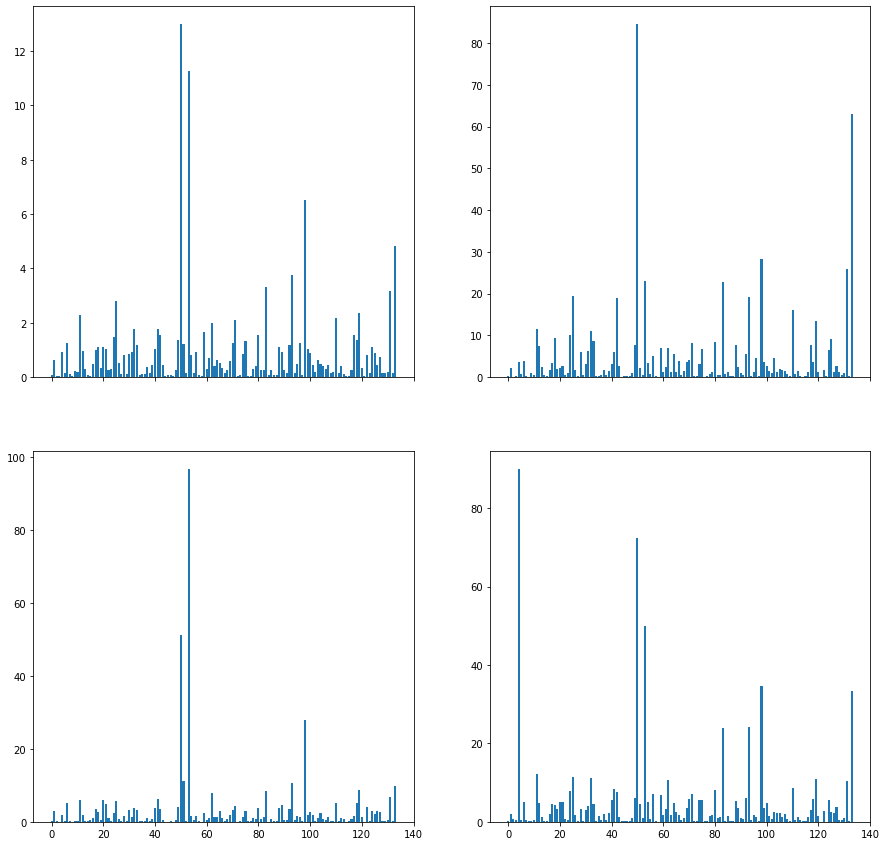

In [224]:
f,arr = plt.subplots(2,2,sharex=True,figsize=(15,15))

c1_count = len(cluster_product[cluster_product['cluster']==0])

c0 = cluster_product[cluster_product['cluster']==0].drop('cluster',axis=1).mean()
arr[0,0].bar(range(len(cluster_product.drop('cluster',axis=1).columns)),c0)
c1 = cluster_product[cluster_product['cluster']==1].drop('cluster',axis=1).mean()
arr[0,1].bar(range(len(cluster_product.drop('cluster',axis=1).columns)),c1)
c2 = cluster_product[cluster_product['cluster']==2].drop('cluster',axis=1).mean()
arr[1,0].bar(range(len(cluster_product.drop('cluster',axis=1).columns)),c2)
c3 = cluster_product[cluster_product['cluster']==3].drop('cluster',axis=1).mean()
arr[1,1].bar(range(len(cluster_product.drop('cluster',axis=1).columns)),c3)

plt.show()

In [225]:
c0.sort_values(ascending=False)[0:15]

aisle
fresh fruits                     12.996203
fresh vegetables                 11.259972
packaged vegetables fruits        6.531537
yogurt                            4.840170
packaged cheese                   3.754606
milk                              3.303043
water seltzer sparkling water     3.169522
chips pretzels                    2.782864
soy lactosefree                   2.349798
bread                             2.279099
refrigerated                      2.169249
ice cream ice                     2.082809
frozen produce                    2.001511
eggs                              1.777967
crackers                          1.766236
dtype: float64

In [226]:
c1.sort_values(ascending=False)[0:15]

aisle
fresh fruits                     84.542404
yogurt                           63.034564
packaged vegetables fruits       28.158321
water seltzer sparkling water    25.796156
fresh vegetables                 22.910808
milk                             22.752150
chips pretzels                   19.475805
packaged cheese                  19.056314
energy granola bars              19.044175
refrigerated                     16.017029
soy lactosefree                  13.445793
bread                            11.522340
crackers                         11.004384
cereal                            9.978081
candy chocolate                   9.357781
dtype: float64

In [227]:
c2.sort_values(ascending=False)[0:15]

aisle
fresh vegetables                 96.875269
fresh fruits                     51.391756
packaged vegetables fruits       27.902778
fresh herbs                      11.309857
packaged cheese                  10.643459
yogurt                            9.923566
soy lactosefree                   8.795699
milk                              8.355556
frozen produce                    7.808244
water seltzer sparkling water     6.770072
eggs                              6.175448
canned jarred vegetables          6.095968
bread                             6.019803
chips pretzels                    5.795072
refrigerated                      5.278674
dtype: float64

In [228]:
c3.sort_values(ascending=False)[0:15]

aisle
baby food formula                90.031453
fresh fruits                     72.334056
fresh vegetables                 50.059111
packaged vegetables fruits       34.557484
yogurt                           33.242950
packaged cheese                  24.305315
milk                             23.996746
bread                            12.200651
chips pretzels                   11.457701
crackers                         11.247831
soy lactosefree                  11.003254
frozen produce                   10.577007
water seltzer sparkling water    10.527657
refrigerated                      8.530369
eggs                              8.318330
dtype: float64

c3 클러스터는 baby food formula로 확실하게 클러스터 구분이 된다. 아기가 있는 부모들이라고 볼 수 있을 것 같다.<br>

In [240]:
c0_prod = c0.sort_values(ascending=False)[0:20].index
c1_prod = c1.sort_values(ascending=False)[0:20].index
c2_prod = c2.sort_values(ascending=False)[0:20].index
c3_prod = c3.sort_values(ascending=False)[0:20].index

In [241]:
set(c0_prod) - set(c1_prod) - set(c2_prod) - set(c3_prod)

{'frozen meals', 'soft drinks'}

In [242]:
set(c1_prod) - set(c0_prod) - set(c2_prod) - set(c3_prod)

{'candy chocolate', 'cream', 'fresh dips tapenades', 'tea'}

In [243]:
set(c2_prod) - set(c0_prod) - set(c1_prod) - set(c3_prod)

{'baking ingredients',
 'canned jarred vegetables',
 'canned meals beans',
 'fresh herbs',
 'oils vinegars',
 'soup broth bouillon'}

In [244]:
set(c3_prod) - set(c0_prod) - set(c1_prod) - set(c2_prod)

{'baby food formula', 'frozen breakfast'}

In [264]:
n_order_df = order_products_prior.groupby("product_id", as_index=False).count()

In [272]:
less_ordered = n_order_df.loc[n_order_df.order_id < 100, 'product_id'].tolist()

In [273]:
products.loc[products.product_id.isin(less_ordered)]

,product_id,product_name,aisle_id,department_id
1,2,All-Seasons Salt,104,13
4,5,Green Chile Anytime Sauce,5,13
5,6,Dry Nose Oil,11,11
6,7,Pure Coconut Water With Orange,98,7
12,13,Saline Nasal Mist,11,11
...,...,...,...,...
49680,49681,Spaghetti with Meatballs and Sauce Meal,38,1
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8
